# Search and Load CMIP6 Data via ESGF / OPeNDAP

This notebooks shows how to search and load data via [Earth System Grid Federation](https://esgf.llnl.gov/) infrastructure. This infrastructure works great and is the foundation of the CMIP6 distribution system.

The main technologies used here are the [ESGF search API](https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API), used to figure out what data we want, and [OPeNDAP](https://www.opendap.org/), a remote data access protocol over HTTP.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

### Search using ESGF API

In [2]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [3]:
result = esgf_search(activity_id='CMIP', table_id='Amon', variable_id='tas', experiment_id='historical',
                  institution_id="NCAR", source_id="CESM2", member_id="r10i1p1f1")
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&table_id=Amon&variable_id=tas&experiment_id=historical&institution_id=NCAR&source_id=CESM2&member_id=r10i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0


['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_185001-189912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_190001-194912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_195001-199912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_200001-201412.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2_historical_r10i1p1f1_gn_185001-189912.nc',
 'http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/CMIP/NCAR/CESM2/historical/r10i1p1f1/Amon/tas/gn/v20190313/tas_Amon_CESM2

### Load Data with Xarray

These are OPeNDAP endpoints. Xarray, together with the netCDF4 python library, allow lazy loading.

In [4]:
# there are mulitple sources of the same data--need to pick one
files_to_open = result[-4:]

ds = xr.open_mfdataset(files_to_open, combine='by_coords')
ds

/Users/rpa/Code/xarray/xarray/conventions.py:494: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 1980)
Coordinates:
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    time_bnds  (time, nbnd) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    lat_bnds   (time, lat, nbnd) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnd) float64 dask.array<chunksize=(600, 288, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            674885.0
    branch_time_in_parent:           306600.0
    case_id:                         24
    cesm_casename:                   b.e21.BHIST.f09_g17.CMIP6-historical.010
    contact:                         cesm_cmip6@ucar.edu
    creation_date:                   2019-03-12T06:39:18Z
    data_specs_version:              01.00.29
    experiment:                      Simulation of recent past (1850 to 2014)...
    experiment_id:                   historical
    external_variables:              areacella
    forcing_index:                   1
    frequency:                       mon
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NCA...
    grid:                            native 0.9x1.25 finite volume grid (192x...
    grid_label:                      gn
    initialization_index:            1
    institution:                     National Center for Atmospheric Research...
    institution_id:                  NCAR
    license:                         CMIP6 model data produced by <The Nation...
    mip_era:                         CMIP6
    model_doi_url:                   https://doi.org/10.5065/D67H1H0V
    nominal_resolution:              100 km
    parent_activity_id:              CMIP
    parent_experiment_id:            piControl
    parent_mip_era:                  CMIP6
    parent_source_id:                CESM2
    parent_time_units:               days since 0001-01-01 00:00:00
    parent_variant_label:            r1i1p1f1
    physics_index:                   1
    product:                         model-output
    realization_index:               10
    realm:                           atmos
    source:                          CESM2 (2017): atmosphere: CAM6 (0.9x1.25...
    source_id:                       CESM2
    source_type:                     AOGCM BGC
    sub_experiment:                  none
    sub_experiment_id:               none
    table_id:                        Amon
    tracking_id:                     hdl:21.14100/e47b79db-3925-45a7-9c0a-679...
    variable_id:                     tas
    variant_info:                    CMIP6 20th century experiments (1850-201...
    variant_label:                   r10i1p1f1
    DODS_EXTRA.Unlimited_Dimension:  time

Plot a map from a specific date.

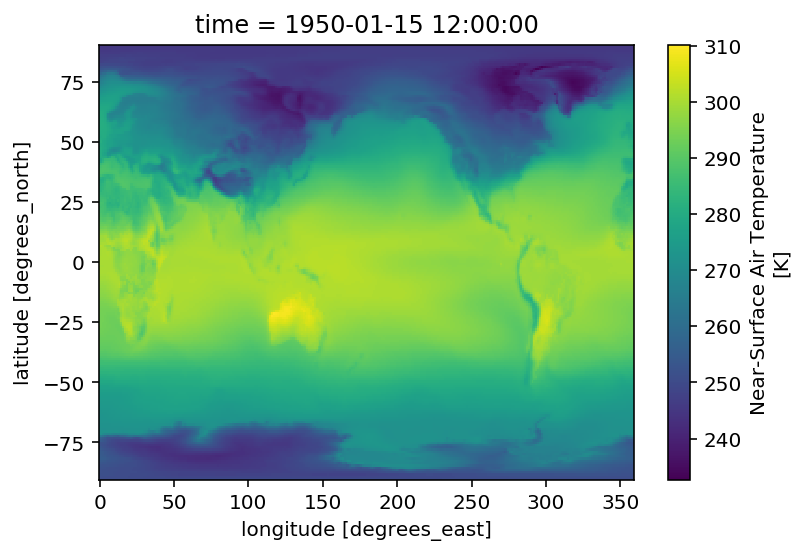

In [5]:
ds.tas.sel(time='1950-01').squeeze().plot()

Create a timeseries of global-average surface air temperature. For this we need the area weighting factor for each gridpoint.

In [6]:
files_area = esgf_search(variable_id='areacella', activity_id='CMIP',
                         experiment_id='historical', institution_id="NCAR", source_id="CESM2")
ds_area = xr.open_dataset(files_area[0])
ds_area

https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?variable_id=areacella&activity_id=CMIP&experiment_id=historical&institution_id=NCAR&source_id=CESM2&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20


/Users/rpa/Code/xarray/xarray/conventions.py:494: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 ...
    lon_bnds   (lon, nbnd) float64 ...
    areacella  (lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  306600.0
    case_id:                24
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.010
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-03-12T06:40:59Z
    data_specs_version:     01.00.29
    experiment:             Simulation of recent past (1850 to 2014). Impose ...
    experiment_id:          historical
    forcing_index:          1
    frequency:              fx
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.h...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    grid_label:             gn
    initialization_index:   1
    institution:            National Center for Atmospheric Research, Climate...
    institution_id:         NCAR
    license:                CMIP6 model data produced by <The National Center...
    mip_era:                CMIP6
    model_doi_url:          https://doi.org/10.5065/D67H1H0V
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       CESM2
    parent_time_units:      days since 0001-01-01 00:00:00
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      10
    realm:                  atmos land
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    source_id:              CESM2
    source_type:            AOGCM BGC
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               fx
    tracking_id:            hdl:21.14100/54fe4682-51a1-43ca-a7d5-66b7bca3f8c8
    variable_id:            areacella
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r10i1p1f1

In [7]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
ta_timeseries

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [8]:
%time ta_timeseries.load()

CPU times: user 3.67 s, sys: 4.42 s, total: 8.08 s
Wall time: 45.4 s


<xarray.DataArray (time: 1980)>
array([284.99948, 285.23215, 285.85364, ..., 288.54376, 287.61884,
       287.06284], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

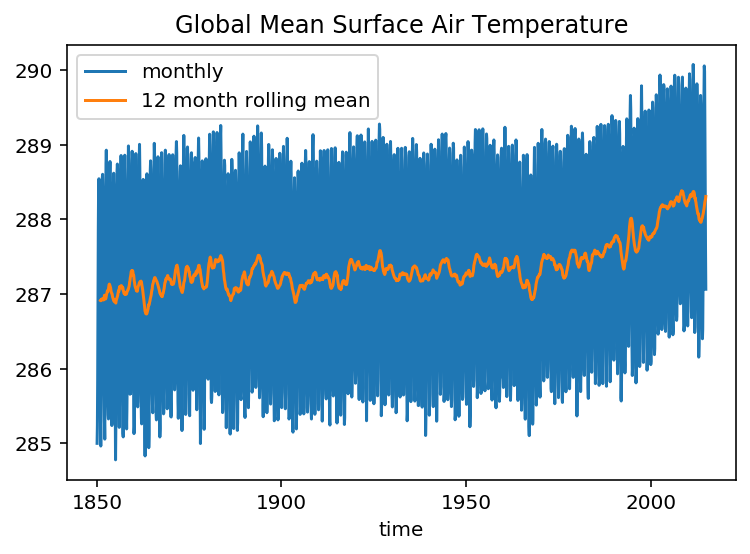

In [9]:
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')